In [2]:
import sys 
sys.path.append("../")

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sn
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score
import umap
import sklearn
import pandas as pd 
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from core.utils import (find_non_numerical_columns,categorize_columns,evaluate_cross_validation,
                   convert_df_to_numeric_df,scale_columns,evaluate_model,optimize_xgb)
%load_ext autoreload
%autoreload 2

/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-pac

In [3]:
df = pd.read_csv("../data/assignement_with_bert_sentiments")
target = df["Exited"]
numerical_df = convert_df_to_numeric_df(df,["RowNumber", "CustomerId", "Surname","CustomerFeedback","Exited"])
numerical_df["RatioSalary"] = numerical_df["EstimatedSalary"] /  (numerical_df["Balance (EUR)"]+1)
numerical_df["RatioProducst"] = numerical_df["NumberOfProducts"] / (numerical_df["Tenure"] +1)
numerical_df["RatioCards"] = numerical_df["HasCreditCard"] &  numerical_df["IsActiveMember"]
numerical_df["ProductSalary"] = numerical_df["Balance (EUR)"] *  numerical_df["CreditScore"]



scaled_df, scaler = scale_columns(numerical_df,columns=["EstimatedSalary","Balance (EUR)","CreditScore","Age","Tenure","RatioSalary",
                                    "RatioProducst","RatioCards","ProductSalary"],return_scaler=True)

In [169]:
import pickle

with open('../models/scaler.pkl','wb') as f :
    pickle.dump(scaler,f)
scaled_df

,EstimatedSalary,Balance (EUR),CreditScore,Age,Tenure,RatioSalary,RatioProducst,RatioCards,ProductSalary,Unnamed: 0,NumberOfProducts,HasCreditCard,IsActiveMember,SentimentsDictionnaryBert,Country_cat,Gender_cat
0,0.797217,1.354197,2.001803,-1.994969,-1.041760,-0.608025,-0.100194,-0.75114,2.062836,0,1,0,0,0,0,1
1,0.468183,1.206470,0.056609,-1.994969,1.724464,-0.608026,-0.817970,-0.75114,1.192608,1,1,0,1,2,0,1
2,-0.491732,0.100675,-0.833213,-1.994969,-0.350204,-0.608025,-0.494971,-0.75114,-0.062711,2,1,1,0,-1,0,0
3,1.690765,0.837543,0.677416,-1.994969,-0.695982,-0.608014,-0.346929,-0.75114,1.015839,3,1,0,0,-1,1,0
4,-0.924205,0.914583,0.791230,-1.994969,-0.350204,-0.608034,-0.494971,1.33131,1.133531,4,1,1,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.537088,0.182509,-2.509391,4.298368,1.032908,-0.608004,-0.758155,-0.75114,-0.334129,9995,1,0,0,0,0,0
9996,0.286009,-1.225848,1.412037,4.393722,1.724464,1.371120,-0.548804,1.33131,-1.193370,9996,2,1,1,2,0,0
9997,-0.819683,-1.225848,-1.422980,4.679783,1.724464,0.291246,-0.548804,1.33131,-1.193370,9997,2,1,1,-1,2,1
9998,1.660193,0.721659,1.060247,5.061197,-0.695982,-0.608013,-0.346929,-0.75114,0.999517,9998,1,0,1,-1,0,1


In [170]:
#df_encoded = pd.get_dummies(scaled_df, columns=["Country_cat"], prefix=["Country"])
#df_encoded = pd.get_dummies(df_encoded, columns=["Gender_cat"], prefix=["Gender"])
#df_encoded = pd.get_dummies(df_encoded, columns=["SentimentsDictionnaryBert"], prefix=["SentimentsDictionnaryBert"])
df_encoded = scaled_df

In [171]:
scaled_df = df_encoded.reset_index(drop=True).drop(columns=["Unnamed: 0"])

In [172]:
scaled_df

,EstimatedSalary,Balance (EUR),CreditScore,Age,Tenure,RatioSalary,RatioProducst,RatioCards,ProductSalary,NumberOfProducts,HasCreditCard,IsActiveMember,SentimentsDictionnaryBert,Country_cat,Gender_cat
0,0.797217,1.354197,2.001803,-1.994969,-1.041760,-0.608025,-0.100194,-0.75114,2.062836,1,0,0,0,0,1
1,0.468183,1.206470,0.056609,-1.994969,1.724464,-0.608026,-0.817970,-0.75114,1.192608,1,0,1,2,0,1
2,-0.491732,0.100675,-0.833213,-1.994969,-0.350204,-0.608025,-0.494971,-0.75114,-0.062711,1,1,0,-1,0,0
3,1.690765,0.837543,0.677416,-1.994969,-0.695982,-0.608014,-0.346929,-0.75114,1.015839,1,0,0,-1,1,0
4,-0.924205,0.914583,0.791230,-1.994969,-0.350204,-0.608034,-0.494971,1.33131,1.133531,1,1,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.537088,0.182509,-2.509391,4.298368,1.032908,-0.608004,-0.758155,-0.75114,-0.334129,1,0,0,0,0,0
9996,0.286009,-1.225848,1.412037,4.393722,1.724464,1.371120,-0.548804,1.33131,-1.193370,2,1,1,2,0,0
9997,-0.819683,-1.225848,-1.422980,4.679783,1.724464,0.291246,-0.548804,1.33131,-1.193370,2,1,1,-1,2,1
9998,1.660193,0.721659,1.060247,5.061197,-0.695982,-0.608013,-0.346929,-0.75114,0.999517,1,0,1,-1,0,1


In [173]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(scaled_df, target.values, test_size=0.2, random_state=0, stratify=target.values)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:19<00:00,  5.04trial/s, best loss: -0.7874530925378382]
Best set of hyperparameters:  {'learning_rate': 0.1916314467373175, 'max_depth': 6, 'scale_pos_weight': 3, 'subsample': 0.9982615130740838}
 balanced accuracy is 0.7692175997260743
 AUC is 0.7692175997260743


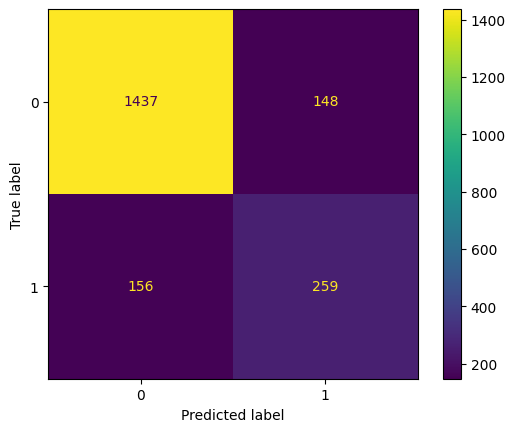

In [174]:
xgb_model = optimize_xgb(scaled_df,target,X_train, y_train,X_test,y_test)


In [175]:
acc = evaluate_cross_validation(scaled_df,xgb_model,target.values,cv=5,test_size=0.2)
print(f"Average cross validation accuracy is {np.mean(acc)}")

Average cross validation accuracy is 0.7919347699008716


In [176]:
import shap
shap.initjs()
X_sampled = X_train.sample(100, random_state=10)


In [177]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sampled)

In [178]:
shap.force_plot(explainer.expected_value, shap_values, X_sampled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


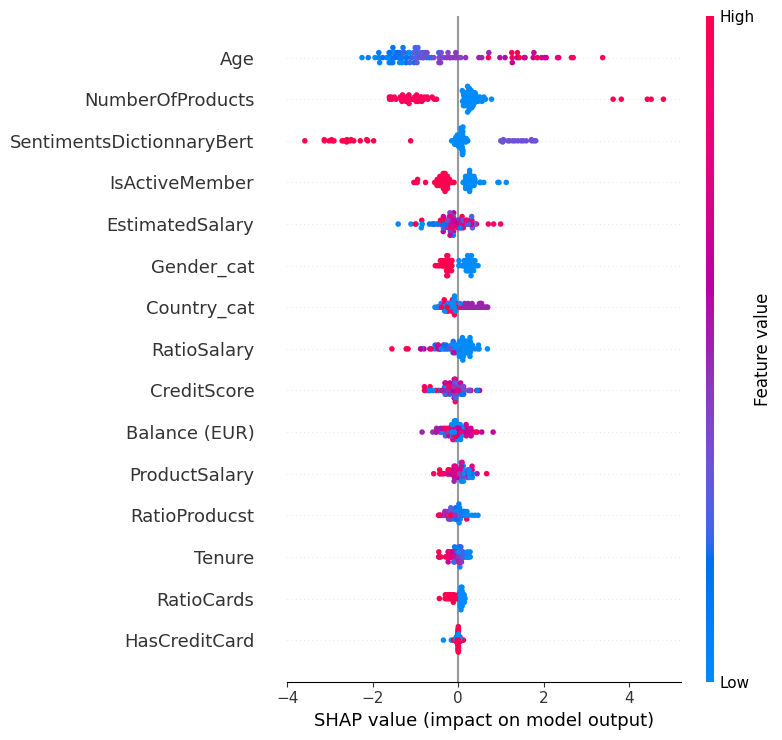

In [179]:
shap.summary_plot(shap_values, X_sampled)

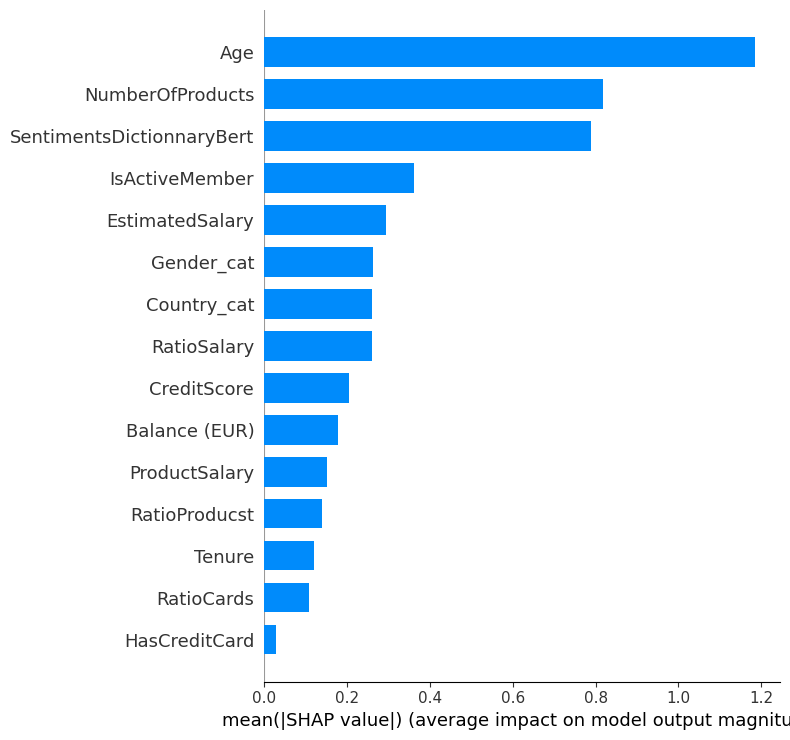

In [180]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

In [162]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [165]:
oversample = SMOTE(sampling_strategy=0.5)
X, y = oversample.fit_resample(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:26<00:00,  3.82trial/s, best loss: -0.7908247230281129]
Best set of hyperparameters:  {'learning_rate': 0.20237511877365838, 'max_depth': 4, 'scale_pos_weight': 1, 'subsample': 0.5089408754097696}
 balanced accuracy is 0.772079475469306
 AUC is 0.772079475469306


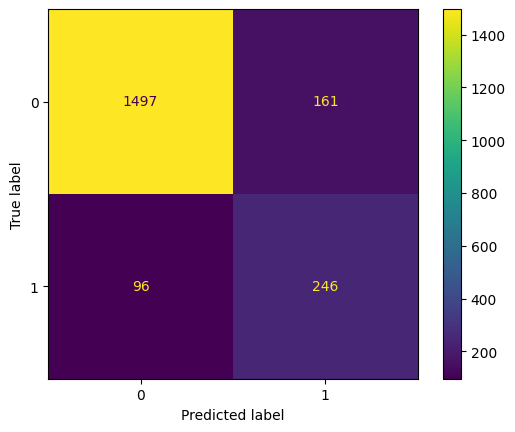

In [166]:
xgb_model = optimize_xgb(scaled_df,target,X, y,X_test,y_test)

In [167]:
acc = evaluate_cross_validation(scaled_df,xgb_model,target.values,cv=5,test_size=0.2)
print(f"Average cross validation accuracy is {np.mean(acc)}")

Average cross validation accuracy is 0.757802486616046
